In [3]:
import torch
from torch import nn

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=8):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        # 利用1x1卷积代替全连接
        self.fc1   = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class cbam_block(nn.Module):
    def __init__(self, channel, ratio=8, kernel_size=7):
        super(cbam_block, self).__init__()
        self.channelattention = ChannelAttention(channel, ratio=ratio)
        self.spatialattention = SpatialAttention(kernel_size=kernel_size)

    def forward(self, x):
        x = x * self.channelattention(x)
        x = x * self.spatialattention(x)
        return x

 
model = cbam_block(512)
print(model)
input = torch.ones([2,512,26,26])
output = model(input)

    

cbam_block(
  (channelattention): ChannelAttention(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (max_pool): AdaptiveMaxPool2d(output_size=1)
    (fc1): Conv2d(512, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (relu1): ReLU()
    (fc2): Conv2d(64, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (sigmoid): Sigmoid()
  )
  (spatialattention): SpatialAttention(
    (conv1): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (sigmoid): Sigmoid()
  )
)


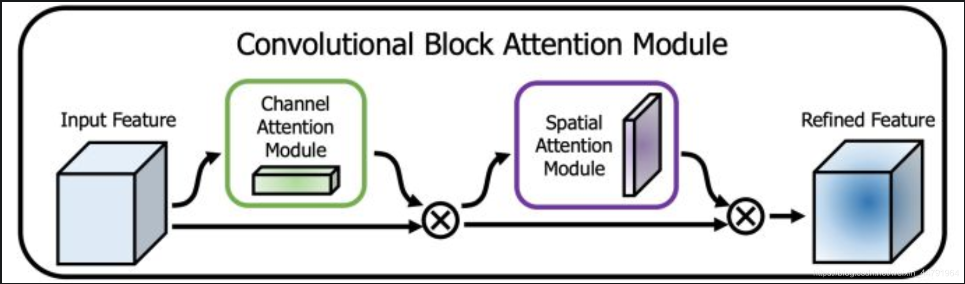

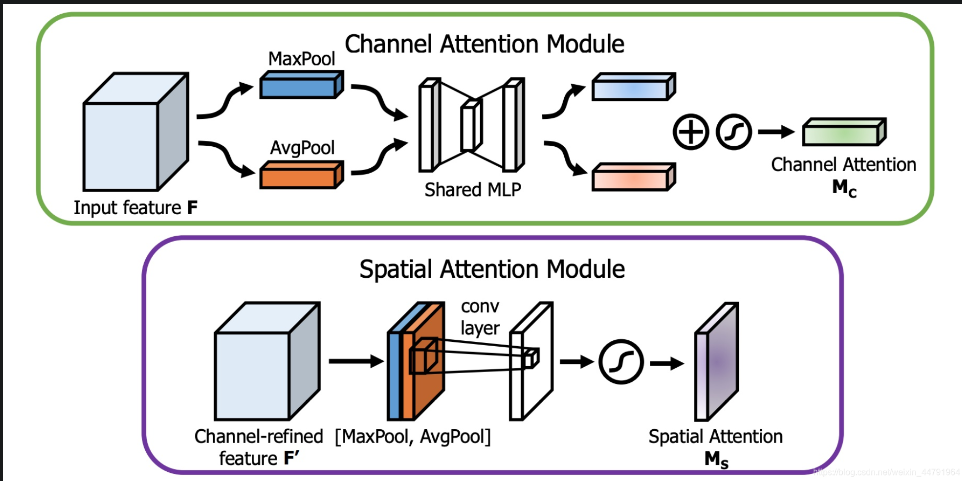